Process whole plane for plane 2 without any downsampling

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Data Files

In [26]:
# Open the HDF5 file
file_path = '/nevis/westside/data/sc5303/Data/bnb_WithWire_16.h5'

with h5py.File(file_path, 'r') as hf:
    # Access the "wire_table" group
    wire_table_group = hf['wire_table']
    startEvt = 0
    endEvt = 10
    # nEvt = endEvt - startEvt
    # Define the start and end indices for the subset you want to load

    # Load the subsets of the data using slicing and convert them to DataFrames
    event_ids = [wire_table_group['event_id'][nEvt*8256] for nEvt in range(startEvt, endEvt)]
    planeadcs = [wire_table_group['adc'][4800+nEvt*8256:8256+nEvt*8256] for nEvt in range(startEvt, endEvt)]

    ntimeticks=6400
    nplanes=len(planeadcs)

    f_downsample = 10
    for p in range(0,nplanes):
        planeadcs[p] = block_reduce(planeadcs[p], block_size=(1,f_downsample), func=np.sum)

    adccutoff = 10.*f_downsample/10.
    adcsaturation = 100.*f_downsample/10.
    for p in range(0,nplanes):
        planeadcs[p][planeadcs[p]<adccutoff] = 0
        planeadcs[p][planeadcs[p]>adcsaturation] = adcsaturation


In [27]:
f_split = 1
X = np.array(np.split(np.array(planeadcs), f_split, axis=2))
print(np.shape(planeadcs))
X = np.reshape(X, (-1,3456,640//f_split,1))
print('X      shape: ' + str(X.shape))


(10, 3456, 640)
X      shape: (10, 3456, 640, 1)


In [55]:
v_split = 2
h_split = 2
print('initial      shape: ' + str(np.array(planeadcs).shape))
Y = np.array(np.split(np.array(planeadcs), v_split, axis=2))
Y = np.array(np.split(np.array(Y), h_split, axis=2))
Y = np.reshape(Y, (-1, 1728,320,1))
print('Y3      shape: ' + str(Y.shape))


initial      shape: (10, 3456, 640)
Y1      shape: (2, 10, 3456, 320)
Y2      shape: (2, 2, 10, 1728, 320)
Y3      shape: (40, 1728, 320, 1)


In [45]:
image = np.array(planeadcs)[0]
tiles = get_tile_images(image, 1728, 320)

_nrows = int(image.shape[0] / 1728)
_ncols = int(image.shape[1] / 320)

fig, ax = plt.subplots(nrows=_nrows, ncols=_ncols)

for i in range(_nrows):
    for j in range(_ncols):
        ax[i, j].imshow(tiles[i, j]); ax[i, j].set_axis_off();

ValueError: not enough values to unpack (expected 3, got 2)

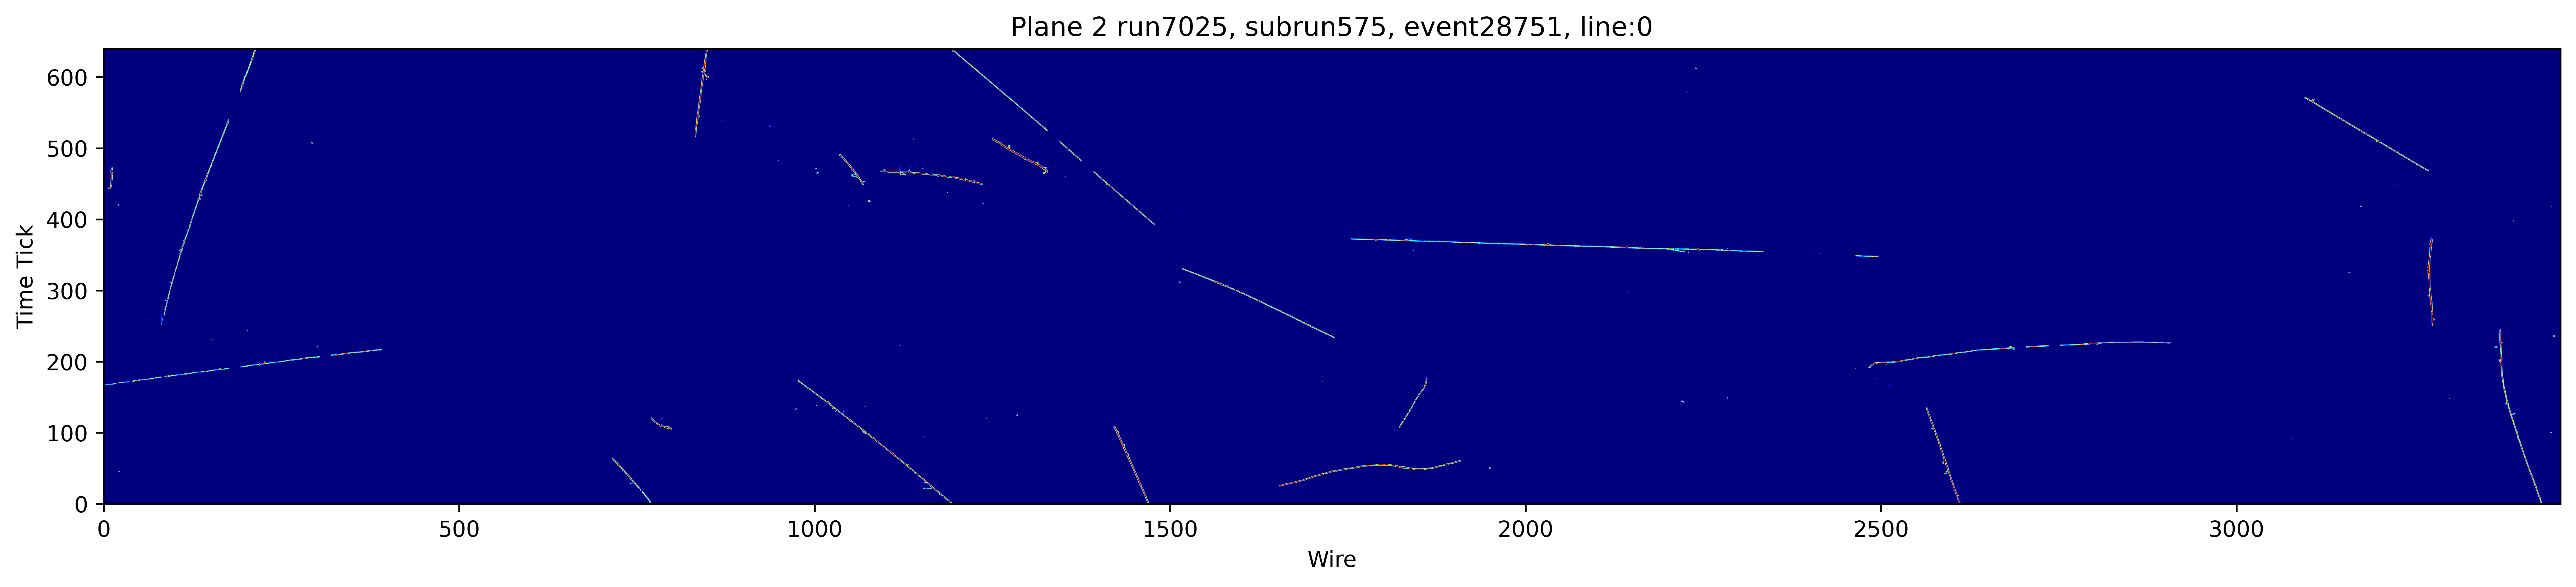

In [29]:
zmax = adcsaturation
# Turn off interactive plotting

fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
true_indice = 0

# Transpose the image
transposed_image = X[true_indice//10][:, :, 0].T

im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
ax1.set_title(f"Plane 2 run{event_ids[true_indice//10][0]}, subrun{event_ids[true_indice//10][1]}, event{event_ids[true_indice//10][2]}, line:{true_indice-(true_indice//10)*10}")
ax1.set_xlabel("Wire")
ax1.set_ylabel("Time Tick")
fig.savefig(f'output/{event_ids[true_indice]}.png')



Text(0, 0.5, 'Time Tick')

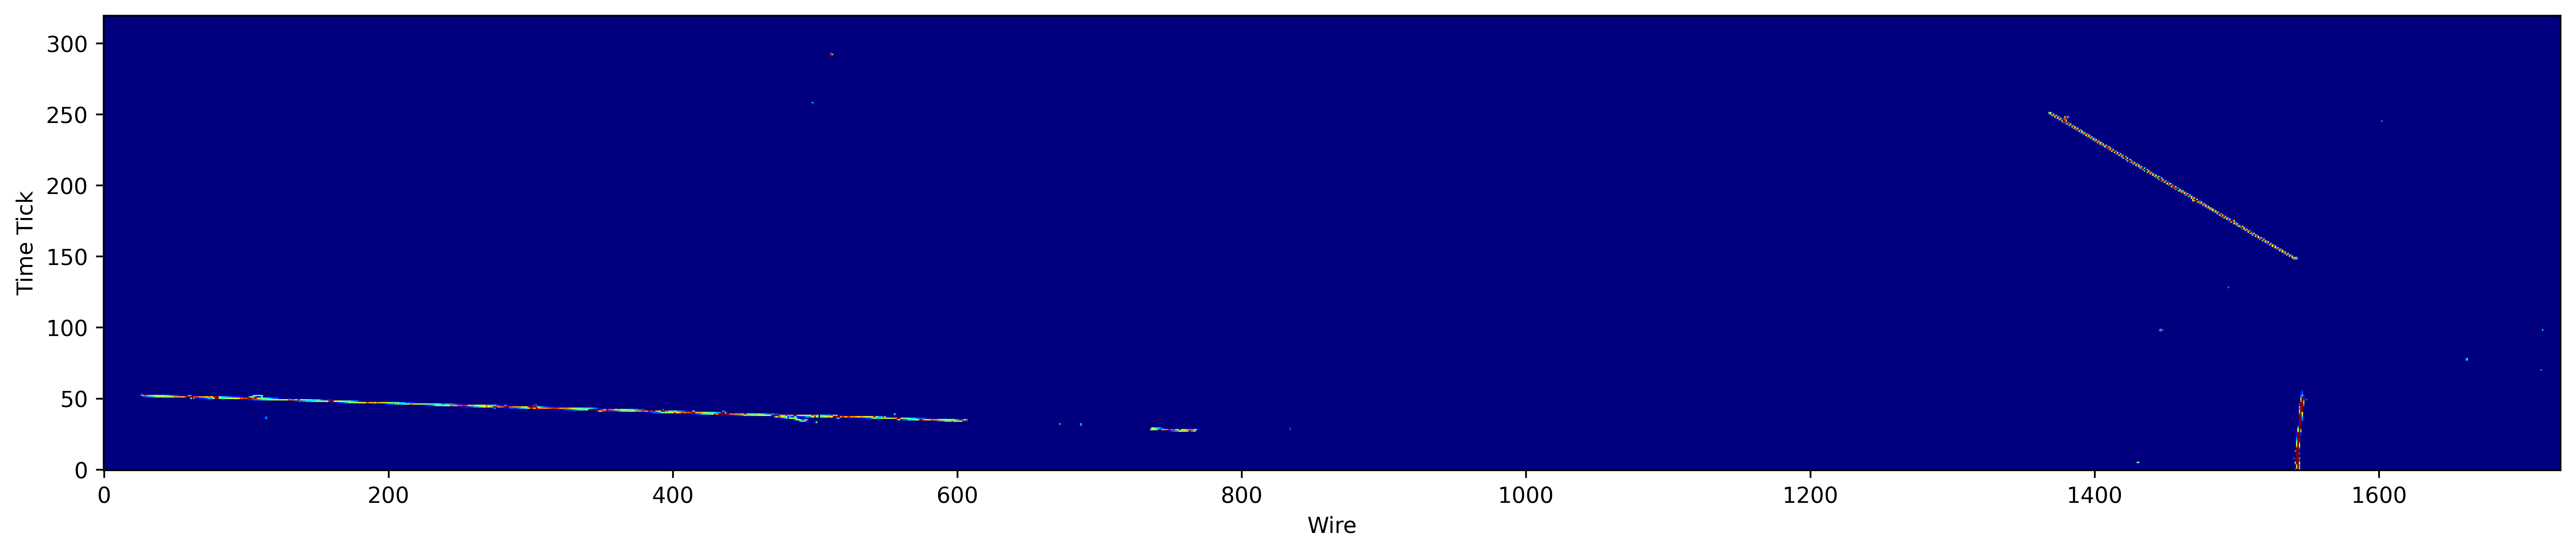

In [70]:
zmax = adcsaturation

fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
true_indice = 30

# Transpose the image
transposed_image = Y[true_indice][:, :, 0].T

im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
# ax1.set_title(f"Plane 2 run{event_ids[true_indice%40][0]}, subrun{event_ids[true_indice%40][1]}, event{event_ids[true_indice%40][2]}, pos:({true_indice//40}, )")
ax1.set_xlabel("Wire")
ax1.set_ylabel("Time Tick")

In [4]:
zmax = adcsaturation
indices_list = [60, 97, 274, 370, 441, 587, 687, 713, 751, 759, 778, 799, 809, 939]
# Turn off interactive plotting
plt.ioff()

for evt in indices_list:
    fig, ax1 = plt.subplots(1, 1, figsize=(20, 15), dpi=600)
    true_indice = evt
    
    # Transpose the image
    transposed_image = X[true_indice//10][:, :, 0].T

    im1 = ax1.imshow(transposed_image, vmin=0, vmax=zmax, origin='lower', cmap='jet')
    ax1.set_title(f"Plane 2 run{event_ids[true_indice//10][0]}, subrun{event_ids[true_indice//10][1]}, event{event_ids[true_indice//10][2]}, line:{true_indice-(true_indice//10)*10}")
    ax1.set_xlabel("Wire")
    ax1.set_ylabel("Time Tick")
    ax1.axhline((true_indice//nEvt)*64, linewidth=0.5, color='yellow', ls='-')
    ax1.axhline((true_indice//nEvt+1)*64, linewidth=0.5, color='yellow', ls='-')

    # Save the figure without displaying it
    fig.savefig(f'output/strips64/full/{event_ids[true_indice//10]}.png')
    # Close the figure to release resources
    plt.close(fig)
# Turn interactive plotting back on
plt.ion()